In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json, os
import string
from sklearn.metrics import confusion_matrix, classification_report
max_len = 16

In [2]:
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams.update({'font.size': 22})


In [3]:
def get_f1s(cm):
    p = [cm[i][i]/(0.00001+cm[i][i]+cm[i][i-1]) for i in range(2)]
    r = [cm[i][i]/(0.00001+cm[i][i]+cm[i-1][i]) for i in range(2)]
    return [2*pp*rr/(pp+rr+0.00001) for pp, rr in zip(p, r)]

In [4]:
def get_maj_f1(cm):
    return get_f1s([[cm[0][0]+cm[0][1], cm[1][0]+cm[1][1]], [0,0]])

In [5]:
def get_rand_f1(cm):
    return get_f1s([[(cm[0][0]+cm[0][1])//2, (cm[0][1]+cm[0][1])//2]]*2)

In [6]:
sum_ct = lambda x: x[0][0] + x[0][1] + x[1][0] + x[1][1]


In [7]:
pred_folders = ["savefolder/"+x for x in os.listdir("savefolder") if 'prd.gpt-j-6B' in x and x.split('.')[-2].endswith('0001')]
control_folders = ["savefolder/"+x for x in os.listdir("savefolder") if 'ctl.gpt-j-6B' in x and x.split('.')[-2].endswith('0001')]


In [8]:
this_f1, this_pos_f1, valid, control_f1, control_pos_f1, num_data, num_data_pos = [{c: 0
                                        for c in string.ascii_lowercase
                                    } for _ in range(7)]
tp_num, fp_num, fn_num, tn_num = [{c: {i: 0 for i in range(max_len)}
                        for c in string.ascii_lowercase} for _ in range(4)]
tp_eg, fp_eg, fn_eg, tn_eg = [{c: {i: [] for i in range(max_len)}
                        for c in string.ascii_lowercase} for _ in range(4)]


In [9]:
for c in string.ascii_lowercase:
    this_len_wise = [[[0, 0], [0, 0]] for _ in range(max_len)]
    for folder in pred_folders:
        gts, prds, _, wds, _ = json.load(open(folder + '/preds_' + c + '.json'))

        for g,p,w in zip(gts, prds, wds):
            if g == 1 and p == 1 and len(tp_eg[c][min(max_len-1,len(w))]) < 5:
                tp_eg[c][min(max_len-1,len(w))].append((w,g,p))
            if g == 0 and p == 0 and len(tn_eg[c][min(max_len-1,len(w))]) < 5:
                tn_eg[c][min(max_len-1,len(w))].append((w,g,p))
            if g == 1 and p == 0 and len(fp_eg[c][min(max_len-1,len(w))]) < 5:
                fp_eg[c][min(max_len-1,len(w))].append((w,g,p))
            if g == 0 and p == 1 and len(fn_eg[c][min(max_len-1,len(w))]) < 5:
                fn_eg[c][min(max_len-1,len(w))].append((w,g,p))
                
            this_len_wise[min(max_len-1,len(w))][g][p] += 1

        this_f1[c]  = {i: sum(get_f1s(this_len_wise[i]))/2 for i in range(max_len)}
        num_data[c] = {i: sum_ct(this_len_wise[i]) for i in range(max_len)}

    for i in range(max_len):
        tp_num[c][i] = this_len_wise[0][1][1]
        fp_num[c][i] = this_len_wise[0][1][0]
        tn_num[c][i] = this_len_wise[0][0][0]
        fn_num[c][i] = this_len_wise[0][0][1]

    this_len_wise = [[[0,0],[0,0]] for _ in range(max_len)]

    for control_folder in control_folders:
        gts, prds, _, wds, _ = json.load(open(control_folder + '/preds_' + c + '.json'))

        for g,p,w in zip(gts, prds, wds):
            this_len_wise[min(max_len-1,len(w))][g][p] += 1

        valid[c] = {i: min(1, sum(x[0])+sum(x[1])) for i, x in enumerate(this_len_wise)}
        control_f1[c] = {i: sum(get_f1s(this_len_wise[i]))/2 for i in range(max_len)}


In [10]:
this_f1['a'][2], tp_eg['a'][2], fp_eg['a'][2], fn_eg['a'][2], tn_eg['a'][2]

(0.9730510212056397,
 [('AA', 1, 1), ('ta', 1, 1), ('ja', 1, 1), ('ea', 1, 1), ('ba', 1, 1)],
 [('mu', 1, 0), ('MY', 1, 0), ('rm', 1, 0), ('md', 1, 0), ('rm', 1, 0)],
 [('ZA', 0, 1), ('Ġa', 0, 1), ('At', 0, 1), ('ZA', 0, 1), ('ZA', 0, 1)],
 [('GE', 0, 0), ('VW', 0, 0), ('BM', 0, 0), ('wu', 0, 0), ('SC', 0, 0)])

this_f1 {'a': 97.31, 'b': 99.27, 'c': 98.96, 'd': 98.39, 'e': 98.58, 'f': 98.08, 'g': 97.47, 'h': 98.59, 'i': 96.53, 'j': 100.0, 'k': 97.74, 'l': 99.22, 'm': 98.45, 'n': 96.01, 'o': 98.69, 'p': 98.2, 'q': 100.0, 'r': 96.82, 's': 97.75, 't': 97.35, 'u': 98.09, 'v': 97.85, 'w': 100.0, 'x': 93.61, 'y': 95.03, 'z': 96.92}

control_f1 {'a': 40.24, 'b': 48.9, 'c': 41.11, 'd': 45.62, 'e': 39.58, 'f': 47.11, 'g': 45.51, 'h': 49.87, 'i': 40.69, 'j': 48.66, 'k': 45.93, 'l': 45.23, 'm': 37.74, 'n': 40.9, 'o': 41.77, 'p': 42.54, 'q': 29.87, 'r': 42.14, 's': 39.91, 't': 41.21, 'u': 52.96, 'v': 43.76, 'w': 51.41, 'x': 47.43, 'y': 45.96, 'z': 53.51}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 819, 'b': 156, 'c': 333, 'd': 320, 'e': 1210, 'f': 125, 'g': 226, 'h': 211, 'i': 779, 'j': 29, 'k': 97, 'l': 429, 'm': 245, '

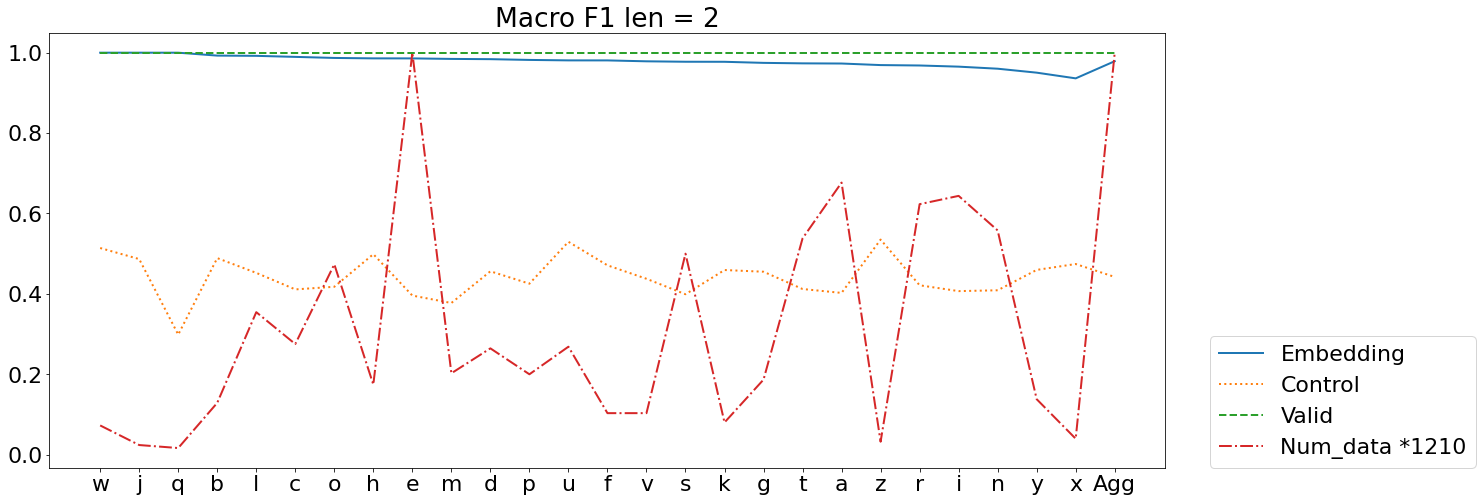

this_f1 {'a': 96.35, 'b': 97.36, 'c': 97.82, 'd': 97.0, 'e': 95.72, 'f': 98.29, 'g': 97.55, 'h': 96.2, 'i': 95.23, 'j': 96.45, 'k': 97.13, 'l': 97.01, 'm': 98.04, 'n': 95.01, 'o': 96.07, 'p': 97.98, 'q': 96.54, 'r': 97.5, 's': 97.68, 't': 96.67, 'u': 95.46, 'v': 97.85, 'w': 96.0, 'x': 98.16, 'y': 97.67, 'z': 98.5}

control_f1 {'a': 47.32, 'b': 52.18, 'c': 44.1, 'd': 47.08, 'e': 46.4, 'f': 47.66, 'g': 48.53, 'h': 48.92, 'i': 46.57, 'j': 47.11, 'k': 46.18, 'l': 44.39, 'm': 48.01, 'n': 45.58, 'o': 48.71, 'p': 46.4, 'q': 47.87, 'r': 44.89, 's': 44.32, 't': 43.36, 'u': 47.95, 'v': 44.65, 'w': 44.74, 'x': 59.46, 'y': 47.3, 'z': 40.36}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 2697, 'b': 524, 'c': 1135, 'd': 1068, 'e': 3765, 'f': 350, 'g': 765, 'h': 724, 'i': 2591, 'j': 89, 'k': 321, 'l': 1414, 'm': 803, '

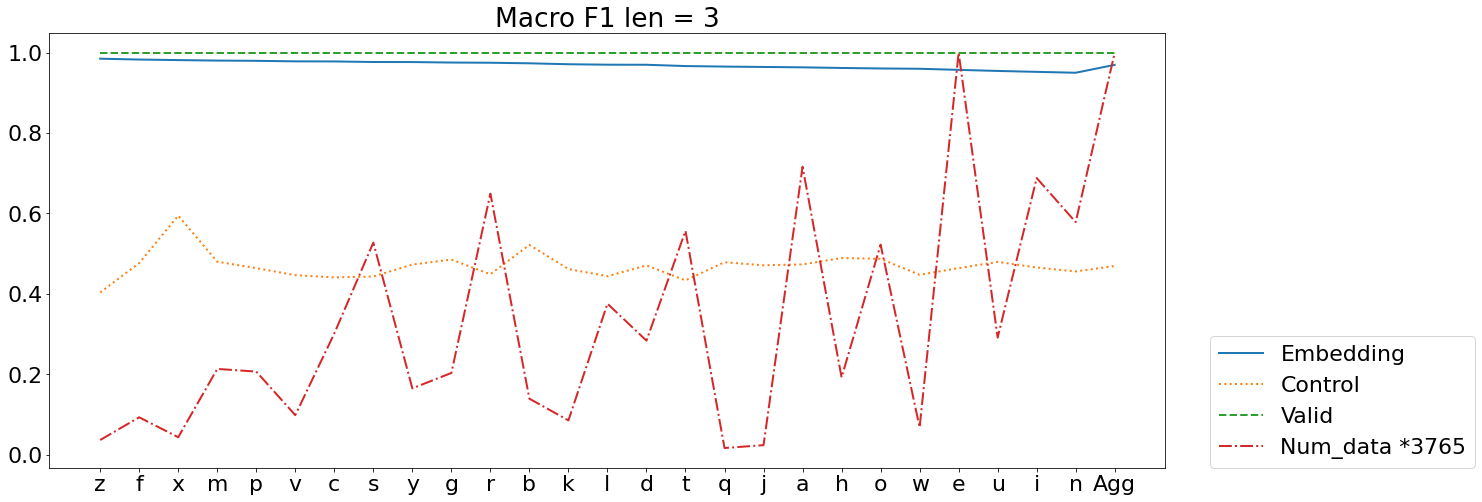

this_f1 {'a': 94.42, 'b': 97.19, 'c': 95.17, 'd': 94.96, 'e': 92.89, 'f': 95.95, 'g': 93.94, 'h': 95.41, 'i': 93.69, 'j': 95.14, 'k': 96.02, 'l': 95.94, 'm': 95.82, 'n': 92.77, 'o': 92.84, 'p': 96.66, 'q': 98.83, 'r': 95.56, 's': 96.13, 't': 95.1, 'u': 92.9, 'v': 95.16, 'w': 96.6, 'x': 98.72, 'y': 96.23, 'z': 98.92}

control_f1 {'a': 49.54, 'b': 49.75, 'c': 46.21, 'd': 49.69, 'e': 48.37, 'f': 48.72, 'g': 47.19, 'h': 49.22, 'i': 47.64, 'j': 46.57, 'k': 47.78, 'l': 50.35, 'm': 48.89, 'n': 47.32, 'o': 48.97, 'p': 47.01, 'q': 48.7, 'r': 48.39, 's': 47.65, 't': 47.23, 'u': 51.02, 'v': 43.17, 'w': 48.24, 'x': 52.7, 'y': 52.32, 'z': 46.17}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 4817, 'b': 899, 'c': 2024, 'd': 1952, 'e': 6414, 'f': 591, 'g': 1313, 'h': 1292, 'i': 4549, 'j': 103, 'k': 578, 'l': 2637, 'm':

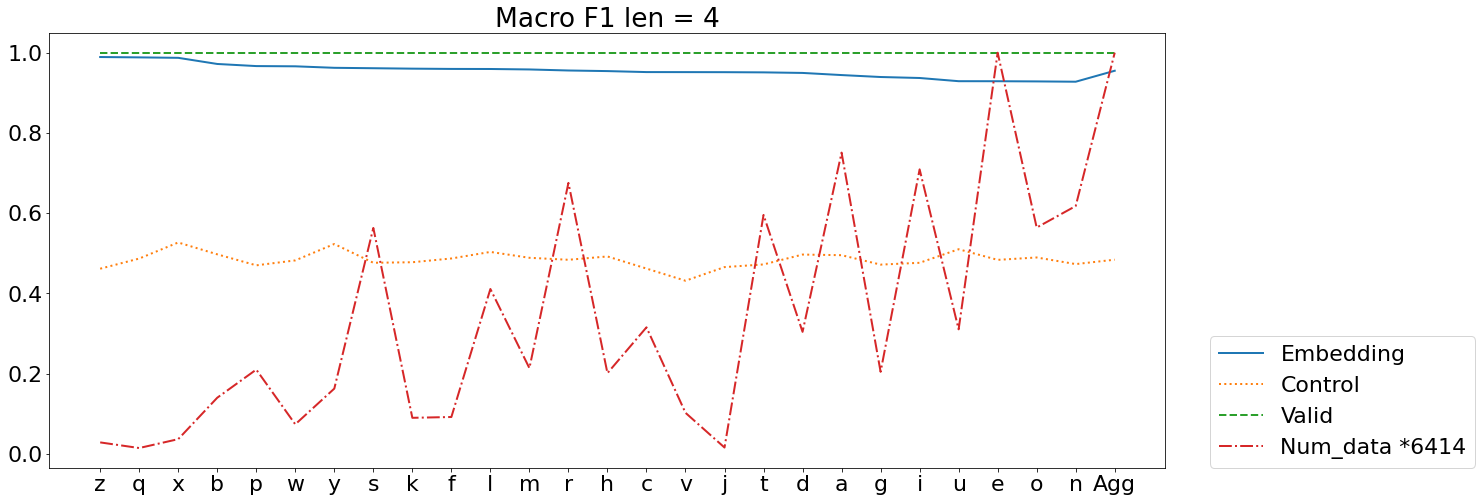

this_f1 {'a': 89.71, 'b': 93.77, 'c': 90.27, 'd': 92.32, 'e': 89.41, 'f': 96.86, 'g': 91.01, 'h': 93.27, 'i': 89.71, 'j': 93.25, 'k': 95.59, 'l': 94.18, 'm': 95.63, 'n': 91.37, 'o': 89.59, 'p': 94.65, 'q': 94.91, 'r': 92.43, 's': 93.17, 't': 91.35, 'u': 88.53, 'v': 93.48, 'w': 95.26, 'x': 95.85, 'y': 91.05, 'z': 95.35}

control_f1 {'a': 50.2, 'b': 48.71, 'c': 49.62, 'd': 49.04, 'e': 49.39, 'f': 53.11, 'g': 50.1, 'h': 50.4, 'i': 48.04, 'j': 45.7, 'k': 49.45, 'l': 49.3, 'm': 47.66, 'n': 48.57, 'o': 48.84, 'p': 50.68, 'q': 36.9, 'r': 48.87, 's': 48.24, 't': 49.08, 'u': 49.59, 'v': 52.91, 'w': 49.88, 'x': 49.62, 'y': 47.96, 'z': 39.38}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 5434, 'b': 976, 'c': 2406, 'd': 2360, 'e': 6989, 'f': 718, 'g': 1600, 'h': 1635, 'i': 5061, 'j': 90, 'k': 735, 'l': 3137, 'm': 1

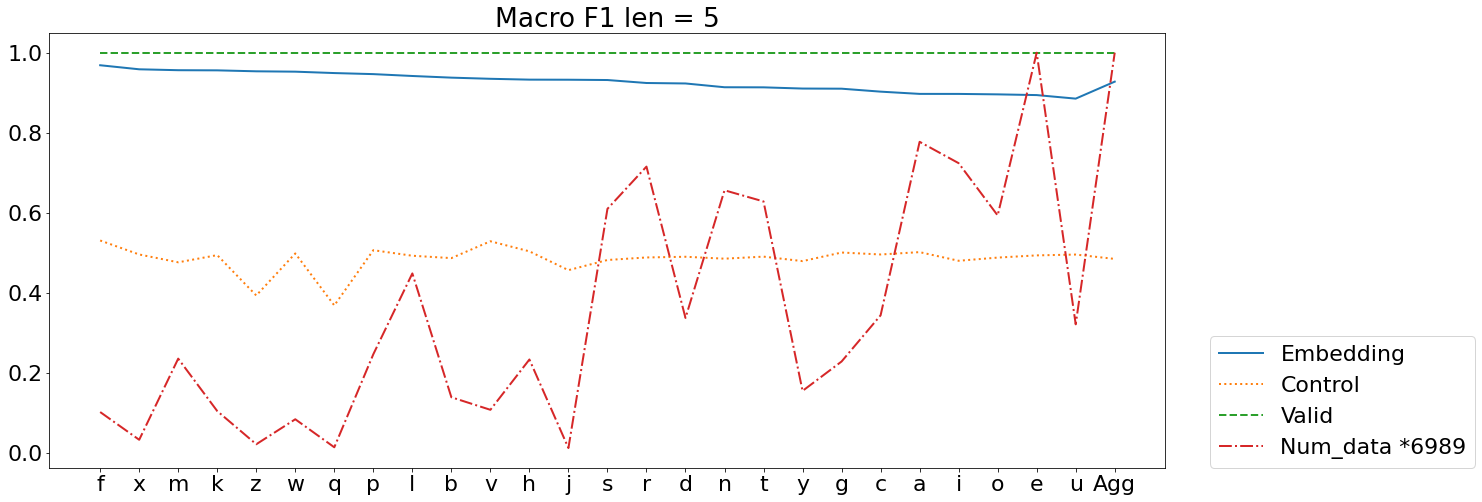

this_f1 {'a': 83.99, 'b': 92.06, 'c': 86.47, 'd': 87.67, 'e': 84.52, 'f': 94.19, 'g': 88.98, 'h': 89.21, 'i': 85.43, 'j': 91.89, 'k': 94.29, 'l': 90.33, 'm': 92.31, 'n': 86.78, 'o': 85.92, 'p': 91.42, 'q': 93.77, 'r': 88.63, 's': 90.59, 't': 88.31, 'u': 84.76, 'v': 89.29, 'w': 94.38, 'x': 92.15, 'y': 90.49, 'z': 93.77}

control_f1 {'a': 50.09, 'b': 54.41, 'c': 50.1, 'd': 52.65, 'e': 49.81, 'f': 51.58, 'g': 52.65, 'h': 48.75, 'i': 50.1, 'j': 40.57, 'k': 52.7, 'l': 50.79, 'm': 50.84, 'n': 50.81, 'o': 50.28, 'p': 48.96, 'q': 48.25, 'r': 49.99, 's': 50.39, 't': 48.98, 'u': 51.36, 'v': 49.53, 'w': 49.0, 'x': 51.14, 'y': 49.25, 'z': 47.18}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 4948, 'b': 983, 'c': 2385, 'd': 2255, 'e': 6276, 'f': 707, 'g': 1601, 'h': 1663, 'i': 4703, 'j': 80, 'k': 685, 'l': 2999, 'm':

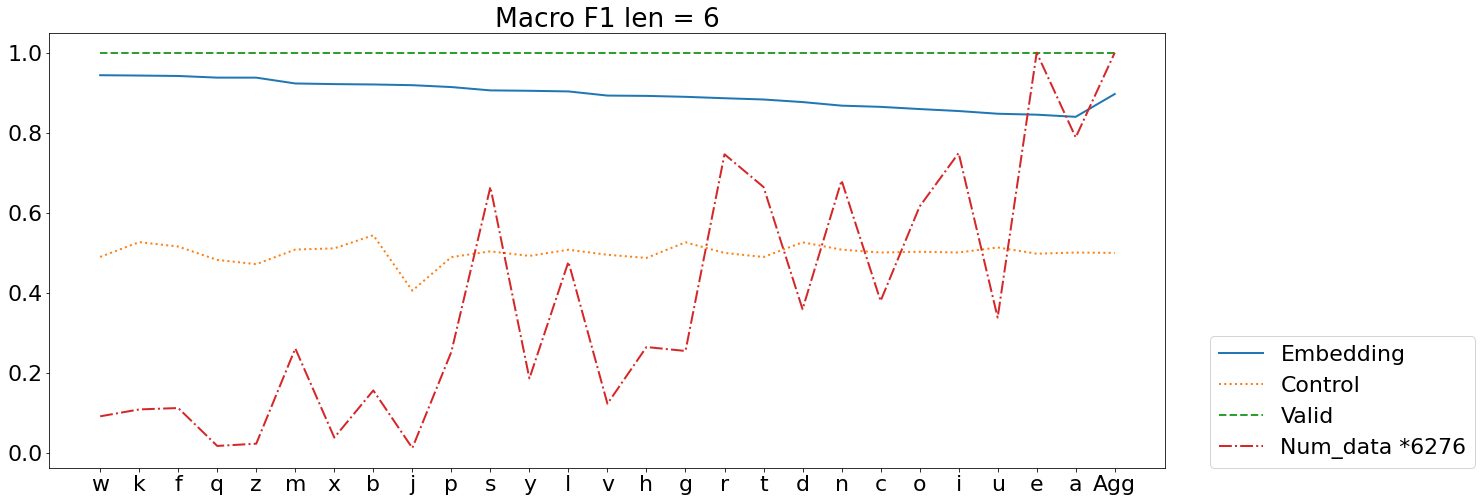

this_f1 {'a': 82.94, 'b': 89.08, 'c': 84.1, 'd': 85.06, 'e': 81.02, 'f': 92.35, 'g': 85.77, 'h': 86.36, 'i': 83.45, 'j': 97.97, 'k': 91.52, 'l': 87.44, 'm': 91.1, 'n': 84.51, 'o': 83.2, 'p': 92.02, 'q': 96.72, 'r': 85.99, 's': 89.3, 't': 85.6, 'u': 80.08, 'v': 88.59, 'w': 94.64, 'x': 95.39, 'y': 89.08, 'z': 91.95}

control_f1 {'a': 48.66, 'b': 48.54, 'c': 48.86, 'd': 48.81, 'e': 49.06, 'f': 53.32, 'g': 48.59, 'h': 48.5, 'i': 49.35, 'j': 37.8, 'k': 50.35, 'l': 48.5, 'm': 50.73, 'n': 51.98, 'o': 51.04, 'p': 52.2, 'q': 46.68, 'r': 50.17, 's': 50.37, 't': 49.16, 'u': 49.2, 'v': 49.2, 'w': 50.99, 'x': 49.81, 'y': 47.3, 'z': 48.53}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 4632, 'b': 973, 'c': 2349, 'd': 2316, 'e': 5846, 'f': 719, 'g': 1669, 'h': 1486, 'i': 4511, 'j': 99, 'k': 623, 'l': 2955, 'm': 1612, '

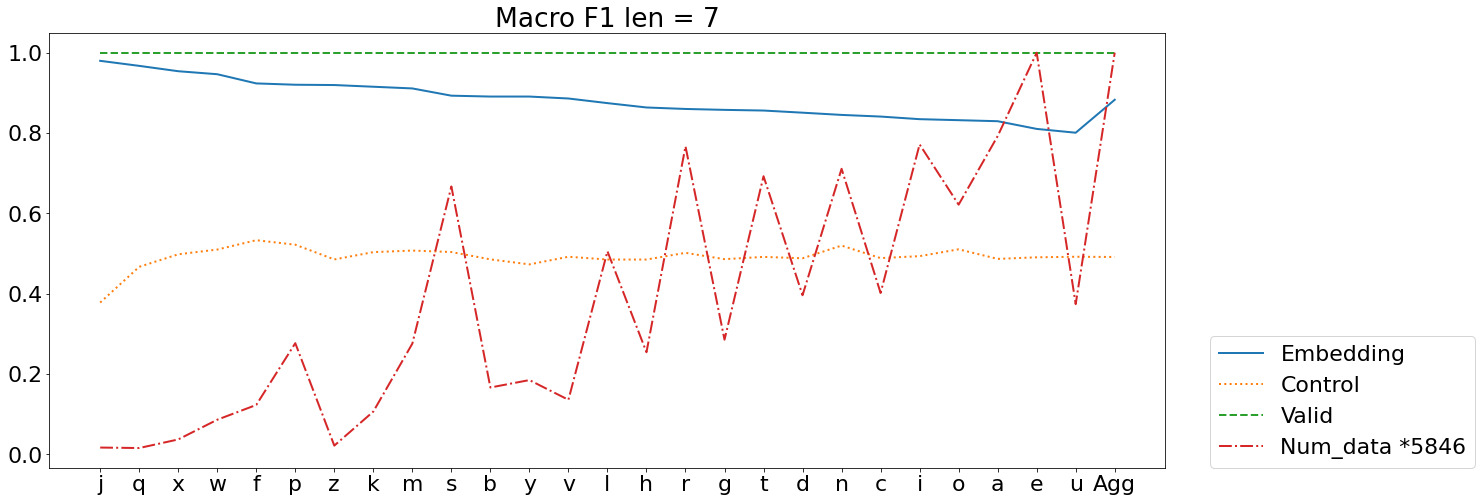

this_f1 {'a': 80.92, 'b': 89.0, 'c': 82.74, 'd': 85.09, 'e': 79.48, 'f': 91.53, 'g': 84.54, 'h': 85.89, 'i': 80.88, 'j': 94.56, 'k': 92.46, 'l': 86.45, 'm': 89.92, 'n': 82.61, 'o': 79.81, 'p': 89.07, 'q': 91.92, 'r': 82.19, 's': 86.03, 't': 84.53, 'u': 78.66, 'v': 89.96, 'w': 91.45, 'x': 94.06, 'y': 88.98, 'z': 87.43}

control_f1 {'a': 50.77, 'b': 49.04, 'c': 49.59, 'd': 50.43, 'e': 48.54, 'f': 48.31, 'g': 49.32, 'h': 51.77, 'i': 50.32, 'j': 50.83, 'k': 53.43, 'l': 51.34, 'm': 51.91, 'n': 49.77, 'o': 50.66, 'p': 48.81, 'q': 41.49, 'r': 47.92, 's': 49.01, 't': 48.54, 'u': 49.93, 'v': 51.3, 'w': 50.0, 'x': 51.85, 'y': 52.46, 'z': 53.51}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 4180, 'b': 839, 'c': 2133, 'd': 2166, 'e': 5098, 'f': 649, 'g': 1690, 'h': 1346, 'i': 4134, 'j': 93, 'k': 528, 'l': 2675, 'm'

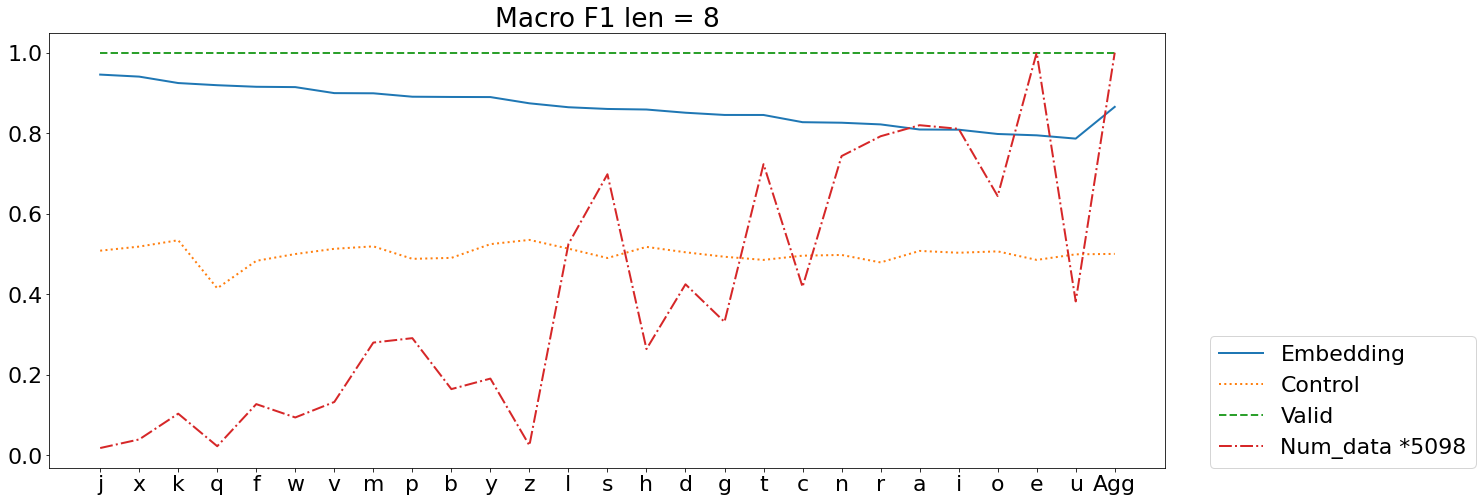

this_f1 {'a': 77.05, 'b': 86.46, 'c': 80.69, 'd': 85.19, 'e': 79.56, 'f': 90.24, 'g': 84.13, 'h': 84.64, 'i': 80.26, 'j': 93.93, 'k': 88.32, 'l': 85.16, 'm': 89.05, 'n': 80.34, 'o': 80.07, 'p': 86.66, 'q': 92.16, 'r': 81.12, 's': 85.24, 't': 80.95, 'u': 76.51, 'v': 83.28, 'w': 92.66, 'x': 89.95, 'y': 86.91, 'z': 82.07}

control_f1 {'a': 49.99, 'b': 48.05, 'c': 49.15, 'd': 48.69, 'e': 49.3, 'f': 46.67, 'g': 49.75, 'h': 47.72, 'i': 48.56, 'j': 48.48, 'k': 51.65, 'l': 51.8, 'm': 46.84, 'n': 50.15, 'o': 48.58, 'p': 51.8, 'q': 58.81, 'r': 49.81, 's': 49.8, 't': 49.16, 'u': 50.56, 'v': 47.84, 'w': 42.67, 'x': 48.55, 'y': 47.53, 'z': 43.33}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 3167, 'b': 641, 'c': 1815, 'd': 1736, 'e': 3838, 'f': 546, 'g': 1254, 'h': 1017, 'i': 3235, 'j': 66, 'k': 355, 'l': 2028, 'm':

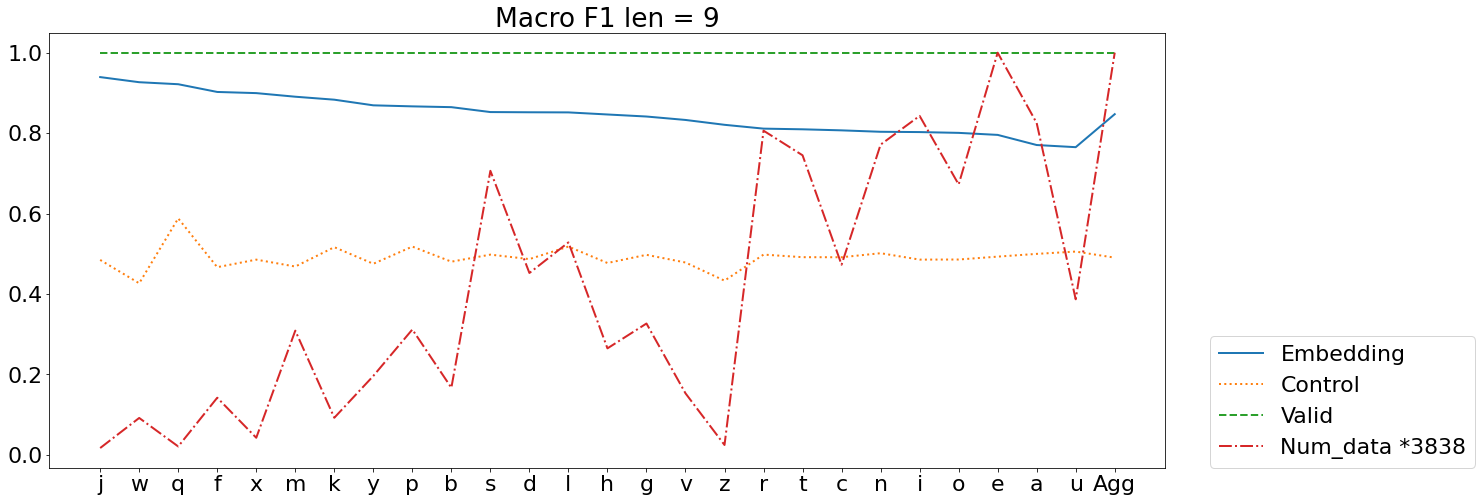

this_f1 {'a': 76.49, 'b': 85.24, 'c': 77.16, 'd': 82.54, 'e': 75.02, 'f': 88.94, 'g': 80.64, 'h': 82.14, 'i': 77.15, 'j': 92.86, 'k': 88.62, 'l': 82.56, 'm': 86.13, 'n': 78.41, 'o': 77.37, 'p': 84.14, 'q': 92.98, 'r': 80.18, 's': 80.61, 't': 79.47, 'u': 74.05, 'v': 82.02, 'w': 95.48, 'x': 91.1, 'y': 84.78, 'z': 93.41}

control_f1 {'a': 49.2, 'b': 49.72, 'c': 48.26, 'd': 50.62, 'e': 43.85, 'f': 50.75, 'g': 47.21, 'h': 51.03, 'i': 46.32, 'j': 48.15, 'k': 47.35, 'l': 50.25, 'm': 48.4, 'n': 47.83, 'o': 49.35, 'p': 49.87, 'q': 45.0, 'r': 46.54, 's': 49.66, 't': 49.52, 'u': 45.34, 'v': 47.02, 'w': 48.91, 'x': 42.86, 'y': 50.07, 'z': 52.49}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 2330, 'b': 499, 'c': 1464, 'd': 1342, 'e': 2795, 'f': 456, 'g': 948, 'h': 717, 'i': 2412, 'j': 56, 'k': 251, 'l': 1537, 'm': 9

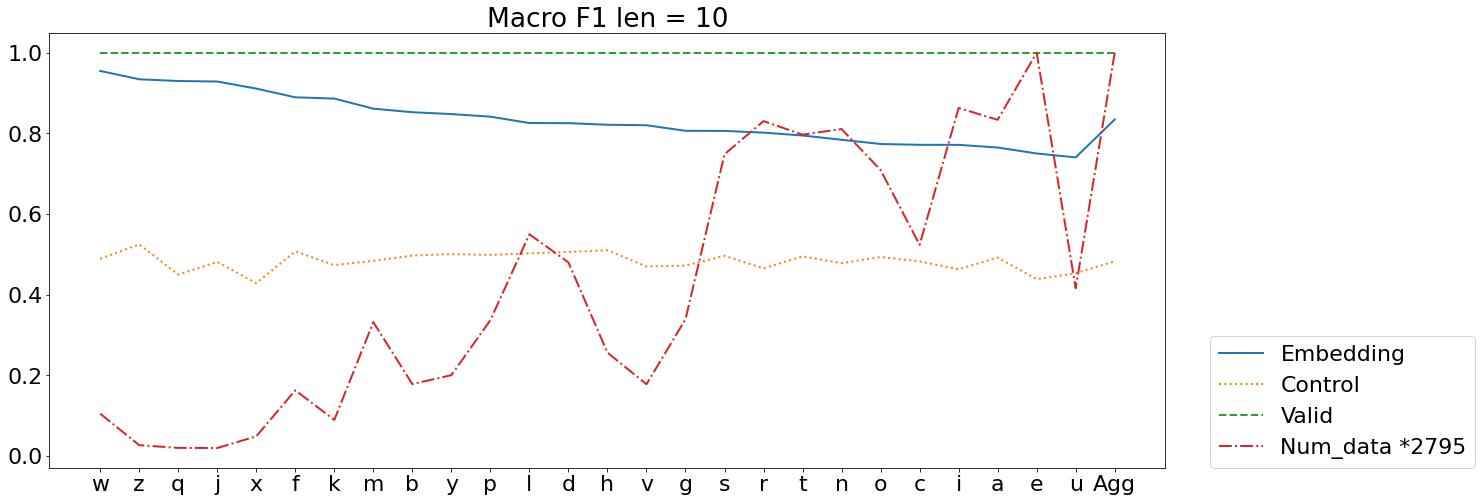

this_f1 {'a': 75.11, 'b': 81.92, 'c': 78.8, 'd': 79.38, 'e': 74.29, 'f': 85.87, 'g': 82.88, 'h': 84.55, 'i': 75.95, 'j': 87.86, 'k': 94.24, 'l': 82.23, 'm': 84.73, 'n': 76.95, 'o': 74.74, 'p': 82.91, 'q': 91.98, 'r': 81.12, 's': 80.93, 't': 74.08, 'u': 73.22, 'v': 81.97, 'w': 95.0, 'x': 89.57, 'y': 82.83, 'z': 98.07}

control_f1 {'a': 50.42, 'b': 49.48, 'c': 47.59, 'd': 51.78, 'e': 45.27, 'f': 51.16, 'g': 49.74, 'h': 49.83, 'i': 43.51, 'j': 51.95, 'k': 48.23, 'l': 48.3, 'm': 46.64, 'n': 45.35, 'o': 47.98, 'p': 50.57, 'q': 47.5, 'r': 46.58, 's': 49.6, 't': 46.64, 'u': 47.5, 'v': 48.69, 'w': 52.84, 'x': 45.82, 'y': 53.15, 'z': 52.0}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 1617, 'b': 388, 'c': 1089, 'd': 899, 'e': 1945, 'f': 317, 'g': 698, 'h': 522, 'i': 1724, 'j': 34, 'k': 132, 'l': 1115, 'm': 699, 

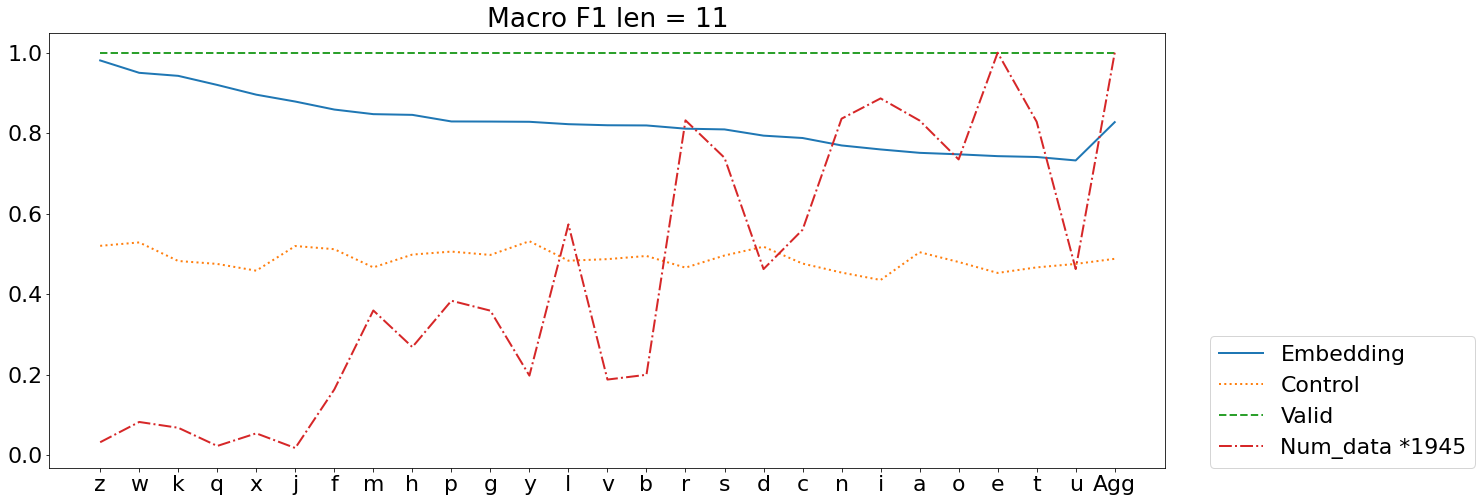

this_f1 {'a': 73.88, 'b': 82.25, 'c': 70.6, 'd': 80.09, 'e': 73.24, 'f': 90.34, 'g': 83.73, 'h': 86.98, 'i': 74.18, 'j': 92.06, 'k': 89.92, 'l': 81.81, 'm': 81.16, 'n': 70.11, 'o': 69.85, 'p': 82.3, 'q': 87.82, 'r': 75.72, 's': 81.73, 't': 72.55, 'u': 74.33, 'v': 71.55, 'w': 93.12, 'x': 94.4, 'y': 87.17, 'z': 87.03}

control_f1 {'a': 49.16, 'b': 49.33, 'c': 46.01, 'd': 49.15, 'e': 46.74, 'f': 42.96, 'g': 53.52, 'h': 43.81, 'i': 45.53, 'j': 38.09, 'k': 49.98, 'l': 49.68, 'm': 48.01, 'n': 42.84, 'o': 45.89, 'p': 49.49, 'q': 56.82, 'r': 45.94, 's': 44.38, 't': 39.88, 'u': 44.03, 'v': 50.06, 'w': 52.83, 'x': 47.59, 'y': 49.49, 'z': 62.07}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 1007, 'b': 222, 'c': 695, 'd': 482, 'e': 1168, 'f': 207, 'g': 382, 'h': 288, 'i': 1088, 'j': 15, 'k': 90, 'l': 721, 'm': 434,

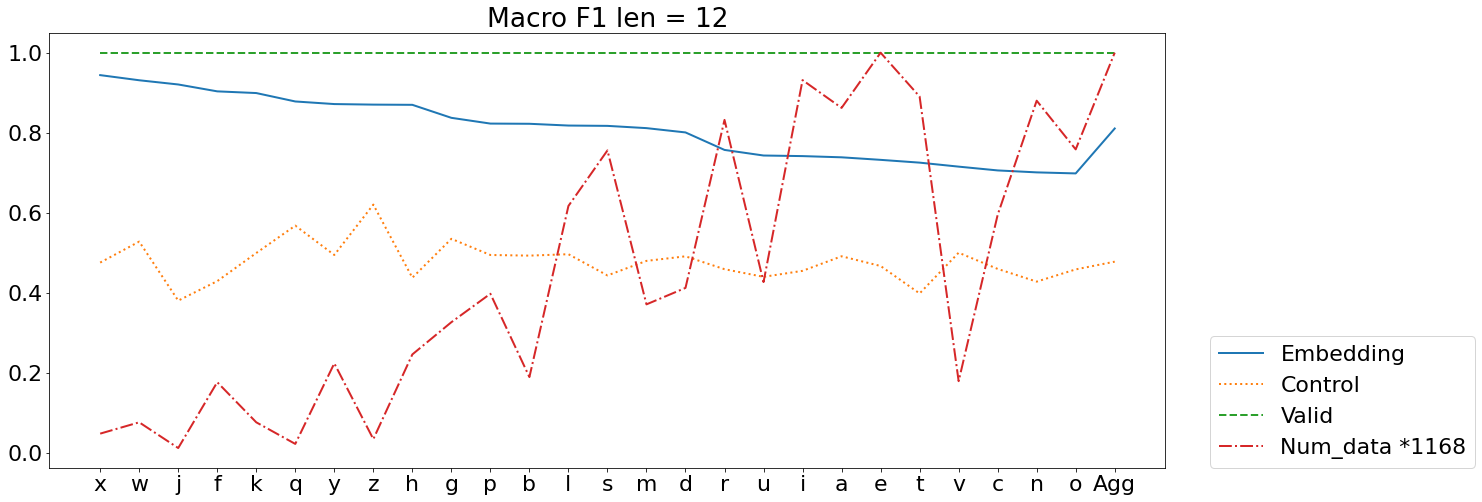

this_f1 {'a': 70.03, 'b': 83.73, 'c': 69.93, 'd': 78.24, 'e': 74.06, 'f': 88.46, 'g': 79.48, 'h': 80.17, 'i': 71.81, 'j': 100.0, 'k': 89.73, 'l': 77.07, 'm': 83.74, 'n': 75.28, 'o': 72.02, 'p': 77.24, 'q': 60.62, 'r': 71.91, 's': 71.67, 't': 63.22, 'u': 71.02, 'v': 75.79, 'w': 85.45, 'x': 92.95, 'y': 80.64, 'z': 89.8}

control_f1 {'a': 45.13, 'b': 52.5, 'c': 42.64, 'd': 48.61, 'e': 51.26, 'f': 42.8, 'g': 41.3, 'h': 49.39, 'i': 41.76, 'j': 33.33, 'k': 54.79, 'l': 47.98, 'm': 48.66, 'n': 45.17, 'o': 45.32, 'p': 45.55, 'q': 32.5, 'r': 46.51, 's': 49.37, 't': 41.66, 'u': 47.54, 'v': 54.38, 'w': 41.53, 'x': 44.97, 'y': 43.91, 'z': 55.56}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 547, 'b': 123, 'c': 380, 'd': 282, 'e': 610, 'f': 99, 'g': 204, 'h': 156, 'i': 566, 'j': 6, 'k': 46, 'l': 390, 'm': 225, 'n': 5

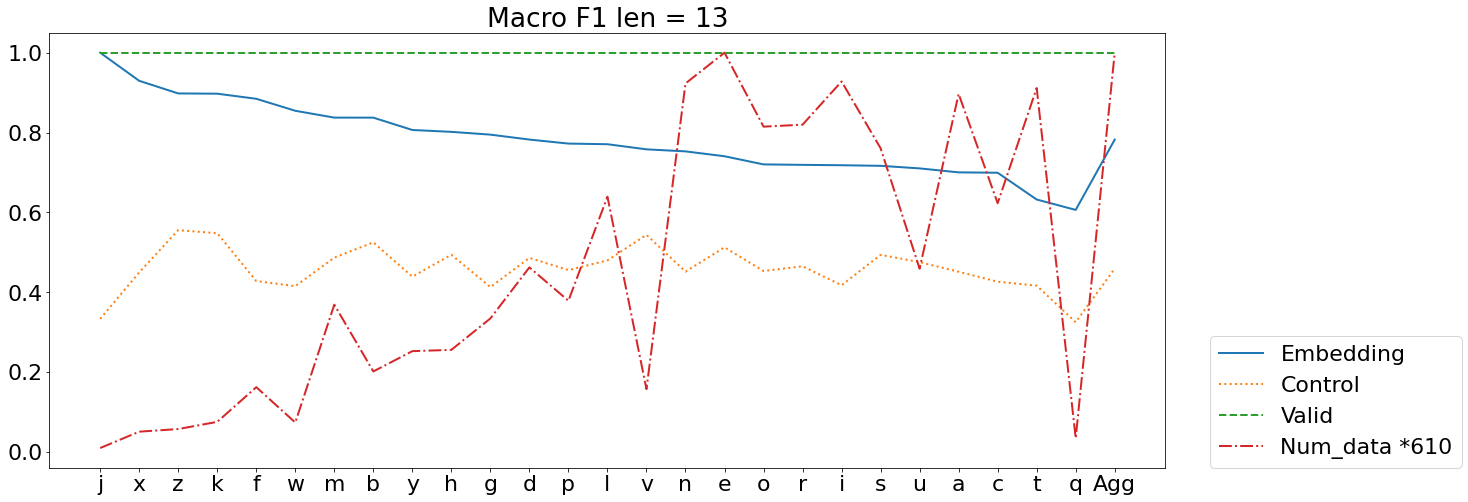

this_f1 {'a': 61.04, 'b': 78.74, 'c': 68.66, 'd': 77.62, 'e': 66.38, 'f': 90.15, 'g': 71.68, 'h': 81.62, 'i': 59.25, 'j': 80.0, 'k': 81.33, 'l': 80.71, 'm': 80.74, 'n': 60.95, 'o': 73.13, 'p': 75.31, 'q': 86.67, 'r': 74.83, 's': 74.56, 't': 64.39, 'u': 70.5, 'v': 85.33, 'w': 79.76, 'x': 72.22, 'y': 83.7, 'z': 79.17}

control_f1 {'a': 44.16, 'b': 59.42, 'c': 42.63, 'd': 41.88, 'e': 46.51, 'f': 54.17, 'g': 48.57, 'h': 49.16, 'i': 36.58, 'j': 66.67, 'k': 34.19, 'l': 52.86, 'm': 43.69, 'n': 38.92, 'o': 43.69, 'p': 45.83, 'q': 20.0, 'r': 44.86, 's': 50.9, 't': 50.02, 'u': 49.02, 'v': 46.28, 'w': 18.18, 'x': 61.45, 'y': 41.37, 'z': 54.76}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 271, 'b': 64, 'c': 178, 'd': 123, 'e': 297, 'f': 51, 'g': 108, 'h': 78, 'i': 284, 'j': 5, 'k': 14, 'l': 169, 'm': 116, 'n': 273

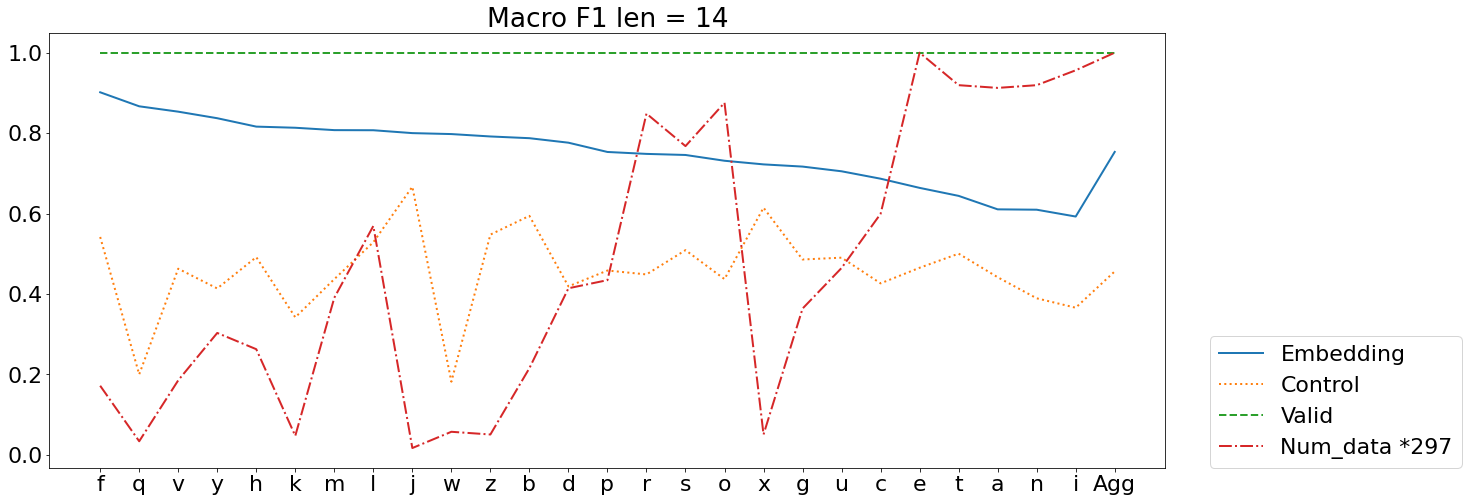

this_f1 {'a': 58.76, 'b': 54.78, 'c': 77.02, 'd': 66.15, 'e': 61.22, 'f': 90.24, 'g': 73.33, 'h': 72.35, 'i': 64.35, 'j': 50.0, 'k': 90.6, 'l': 69.55, 'm': 70.87, 'n': 50.63, 'o': 62.82, 'p': 69.46, 'q': 0.0, 'r': 75.6, 's': 71.92, 't': 62.96, 'u': 53.6, 'v': 57.91, 'w': 83.33, 'x': 100.0, 'y': 77.34, 'z': 100.0}

control_f1 {'a': 39.21, 'b': 32.62, 'c': 48.72, 'd': 40.44, 'e': 49.66, 'f': 43.49, 'g': 53.17, 'h': 46.37, 'i': 43.84, 'j': 0.0, 'k': 16.67, 'l': 49.95, 'm': 39.06, 'n': 38.0, 'o': 41.36, 'p': 51.46, 'q': 50.0, 'r': 40.7, 's': 40.34, 't': 39.3, 'u': 48.75, 'v': 36.51, 'w': 35.41, 'x': 40.0, 'y': 57.13, 'z': 33.33}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 170, 'b': 41, 'c': 100, 'd': 91, 'e': 180, 'f': 41, 'g': 52, 'h': 47, 'i': 179, 'j': 1, 'k': 11, 'l': 114, 'm': 89, 'n': 170, 'o': 159,

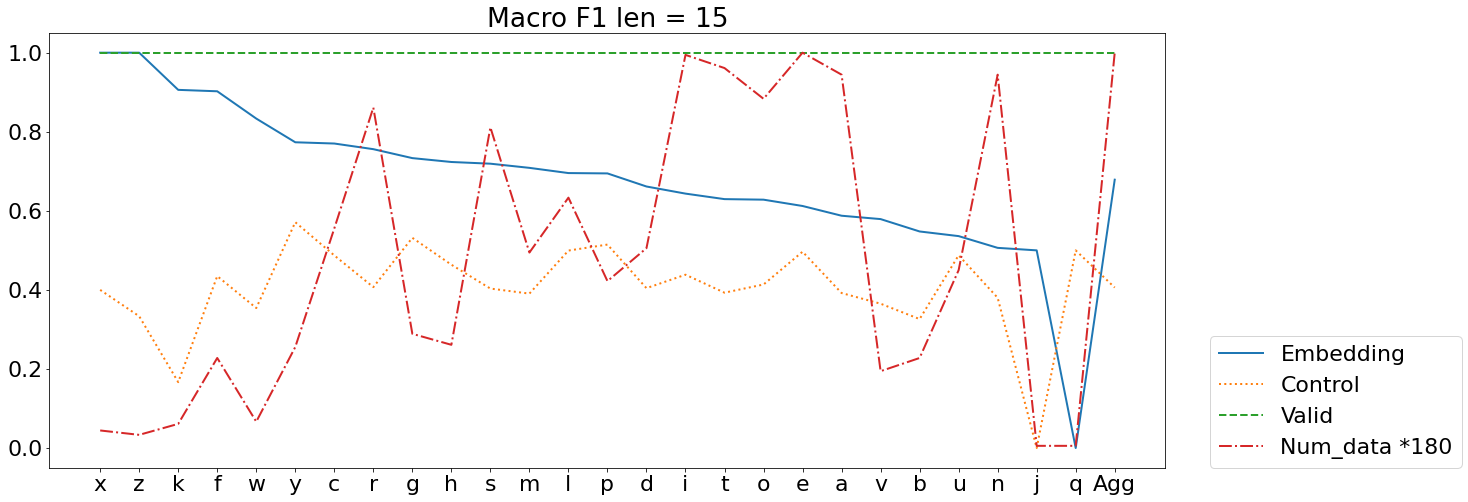

In [14]:
sort = True
sort_by = 1

for l in range(2, max_len):
    print("this_f1", {c: round(this_f1[c][l]*100, 2) for c in string.ascii_lowercase})
    print()
    print("control_f1", {c: round(control_f1[c][l]*100, 2) for c in string.ascii_lowercase})
    print()
    print("valid", {c: valid[c][l] for c in string.ascii_lowercase})
    print()
    print("num_data", {c: num_data[c][l] for c in string.ascii_lowercase})
    print()
    print("tp", {c: (tp_num[c][l], tp_eg[c][l]) for c in string.ascii_lowercase})
    print()
    print("tn", {c: (tn_num[c][l], tn_eg[c][l]) for c in string.ascii_lowercase})
    print()
    print("fp", {c: (fp_num[c][l], fp_eg[c][l]) for c in string.ascii_lowercase})
    print()
    print("fn", {c: (fn_num[c][l], fn_eg[c][l]) for c in string.ascii_lowercase})
    print()

    this_f1_l    = [x[l] for x in this_f1.values()]
    ctrl_f1_l = [x[l] for x in control_f1.values()]
    valid_l      = [x[l] for x in valid.values()]
    num_data_l_o   = [x[l] for x in num_data.values()]
    num_data_l   = [x/max(1, max(num_data_l_o)) for x in num_data_l_o]

    sorted_indices = sorted(list(range(len(this_f1_l))), key = lambda x: -this_f1_l[x])
    sort_it = lambda x: x
    if sort == False:
        sorted_indices = list(range(len(this_f1_l)))
    elif sort_by == 1:
        sort_it = lambda x: [x[y] for y in sorted_indices]
    else:
        sorted_indices = sorted(list(range(len(num_data_l))), key = lambda x: -num_data_l[x])
        sort_it = lambda x: [x[y] for y in sorted_indices]

    fig, ax = plt.subplots()
    plt.plot(sort_it(this_f1_l) + [sum(this_f1_l)/len(this_f1_l)], linestyle='-' , linewidth=2, label='Embedding')
    plt.plot(sort_it(ctrl_f1_l) + [sum(ctrl_f1_l)/len(ctrl_f1_l)], linestyle=':' , linewidth=2, label='Control')
    plt.plot(sort_it(valid_l) + [max(valid_l)], linestyle='--' , linewidth=2, label='Valid')
    plt.plot(sort_it(num_data_l) + [max(num_data_l)], linestyle='-.' , linewidth=2, label='Num_data *' + str(max(num_data_l_o)))
    # ax.plot([3,3.1,3,3.1,3], linestyle='-.' , linewidth=4, label='3')
    # ax.plot([4,4.1,4,4.1,4], linestyle=':' , linewidth=4, label='1')
    ax.set_xticks(range(0,27))
    ax.set_xticklabels(sort_it(list(string.ascii_lowercase)) + ['Agg'])

    # plt.axis('off')
    plt.title('Macro F1 len = ' + str(l))
    plt.legend(loc=(1.04,0))
    plt.show()


In [12]:

def plot_it(pred_folders, control_folders, sort, max_len=16, sort_by=1):
    this_f1, this_pos_f1, valid, control_f1, control_pos_f1, num_data, num_data_pos = [{c: 0
                                                        for c in string.ascii_lowercase
                                                    }
                                                    for _ in range(7)]

    for c in string.ascii_lowercase:
        this_len_wise = [[[0,0],[0,0]] for _ in range(max_len)]
        for folder in pred_folders:
            gts, prds, _, wds, _ = json.load(open(folder + '/preds_' + c + '.json'))
        
            for g,p,w in zip(gts, prds, wds):
                this_len_wise[min(max_len-1,len(w))][g][p] += 1

            this_f1[c]  = {i: sum(get_f1s(this_len_wise[i]))/2 for i in range(max_len)}
            num_data[c] = {i: sum_ct(this_len_wise[i]) for i in range(max_len)}

        this_len_wise = [[[0,0],[0,0]] for _ in range(max_len)]
        for control_folder in control_folders:
            gts, prds, _, wds, _ = json.load(open(control_folder + '/preds_' + c + '.json'))
            
            for g,p,w in zip(gts, prds, wds):
                this_len_wise[min(max_len-1,len(w))][g][p] += 1

            valid[c] = {i: min(1, sum(x[0])+sum(x[1])) for i, x in enumerate(this_len_wise)}
            control_f1[c] = {i: sum(get_f1s(this_len_wise[i]))/2 for i in range(max_len)}

    for l in range(1, max_len):
        this_f1_l    = [x[l] for x in this_f1.values()]
        control_f1_l = [x[l] for x in control_f1.values()]
        valid_l      = [x[l] for x in valid.values()]
        num_data_l_o   = [x[l] for x in num_data.values()]
        num_data_l   = [x/max(1, max(num_data_l_o)) for x in num_data_l_o]

        sorted_indices = sorted(list(range(len(this_f1_l))), key = lambda x: -this_f1_l[x])
        sort_it = lambda x: x
        if sort == False:
            sorted_indices = list(range(len(this_f1_l)))
        elif sort_by == 1:
            sort_it = lambda x: [x[y] for y in sorted_indices]
        else:
            sorted_indices = sorted(list(range(len(num_data_l))), key = lambda x: -num_data_l[x])
            sort_it = lambda x: [x[y] for y in sorted_indices]

        fig, ax = plt.subplots()
        plt.plot(sort_it(this_f1_l), linestyle='-' , linewidth=2, label='Embedding')
        plt.plot(sort_it(control_f1_l), linestyle=':' , linewidth=2, label='Control')
        plt.plot(sort_it(valid_l), linestyle='--' , linewidth=2, label='Valid')
        plt.plot(sort_it(num_data_l), linestyle='-.' , linewidth=2, label='Num_data *' + str(max(num_data_l_o)))
        # ax.plot([3,3.1,3,3.1,3], linestyle='-.' , linewidth=4, label='3')
        # ax.plot([4,4.1,4,4.1,4], linestyle=':' , linewidth=4, label='1')
        ax.set_xticks(range(0,26))
        ax.set_xticklabels(sort_it(list(string.ascii_lowercase)))

        # plt.axis('off')
        plt.title('Macro F1 len = ' + str(l-1))
        plt.legend(loc=(1.04,0))
        plt.show()

    return
    del this_f1_l, control_f1_l, valid_l
    for l in range(1, max_len):
        this_pos_f1_l    = [x[l] for x in this_pos_f1.values()]
        control_pos_f1_l = [x[l] for x in control_pos_f1.values()]
        valid_l      = [x[l] for x in valid.values()]
        num_data_l_o   = [x[l] for x in num_data.values()]
        num_data_l   = [x/max(1, max(num_data_l_o)) for x in num_data_l_o]

        sort_it = lambda x:x
        sorted_indices = sorted(list(range(len(this_pos_f1_l))), key = lambda x: -this_pos_f1_l[x])
        if sort == False:
            sorted_indices = list(range(len(this_pos_f1_l)))
        elif sort_by == 1:
            sort_it = lambda x: [x[y] for y in sorted_indices]
        else:
            sorted_indices = sorted(list(range(len(num_data_l))), key = lambda x: -num_data_l[x])
            sort_it = lambda x: [x[y] for y in sorted_indices]

        fig, ax = plt.subplots()
        plt.plot(sort_it(this_pos_f1_l), linestyle='-' , linewidth=2, label='Embedding')
        plt.plot(sort_it(control_pos_f1_l), linestyle=':' , linewidth=2, label='Control')
        plt.plot(sort_it(valid_l), linestyle='--' , linewidth=2, label='Valid')
        plt.plot(sort_it(num_data_l), linestyle='-.' , linewidth=2, label='Num_data * ' + str(max(num_data_l_o)))
        # ax.plot([2,2.1,2,2.1,2], linestyle='--' , linewidth=4, label='2')
        # ax.plot([3,3.1,3,3.1,3], linestyle='-.' , linewidth=4, label='3')
        # ax.plot([4,4.1,4,4.1,4], linestyle=':' , linewidth=4, label='1')
        ax.set_xticks(range(0,26))
        ax.set_xticklabels(sort_it(list(string.ascii_lowercase)))

        # plt.axis('off')
        plt.title('Pos F1 len = ' + str(l-1))
        plt.legend(loc=(1.04,0))
        plt.show()
